In [6]:
import os
import tarfile
from six.moves import urllib

In [7]:
import pandas as pd

In [8]:
HOUSING_PATH = os.path.join("houses")

In [9]:
def load_housing_data(path=HOUSING_PATH):
    csv_path = os.path.join(path,"housing.csv")
    return pd.read_csv(csv_path)

In [10]:
houses = load_housing_data(HOUSING_PATH)

In [11]:
houses.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [12]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Typem pola ocean_proximity jest object co oznacza, że musi to być wartość tekstowa

In [13]:
houses['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [14]:
houses.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Warości zerowe są ignorowane (dlatego total bedrooms to 20433)

Wygenerowanie histogramu dla każdego atrybutu numerycznego 

In [15]:
%matplotlib inline 

In [16]:
import matplotlib.pyplot as plt

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D2F4BB9320>,
      dtype=object)

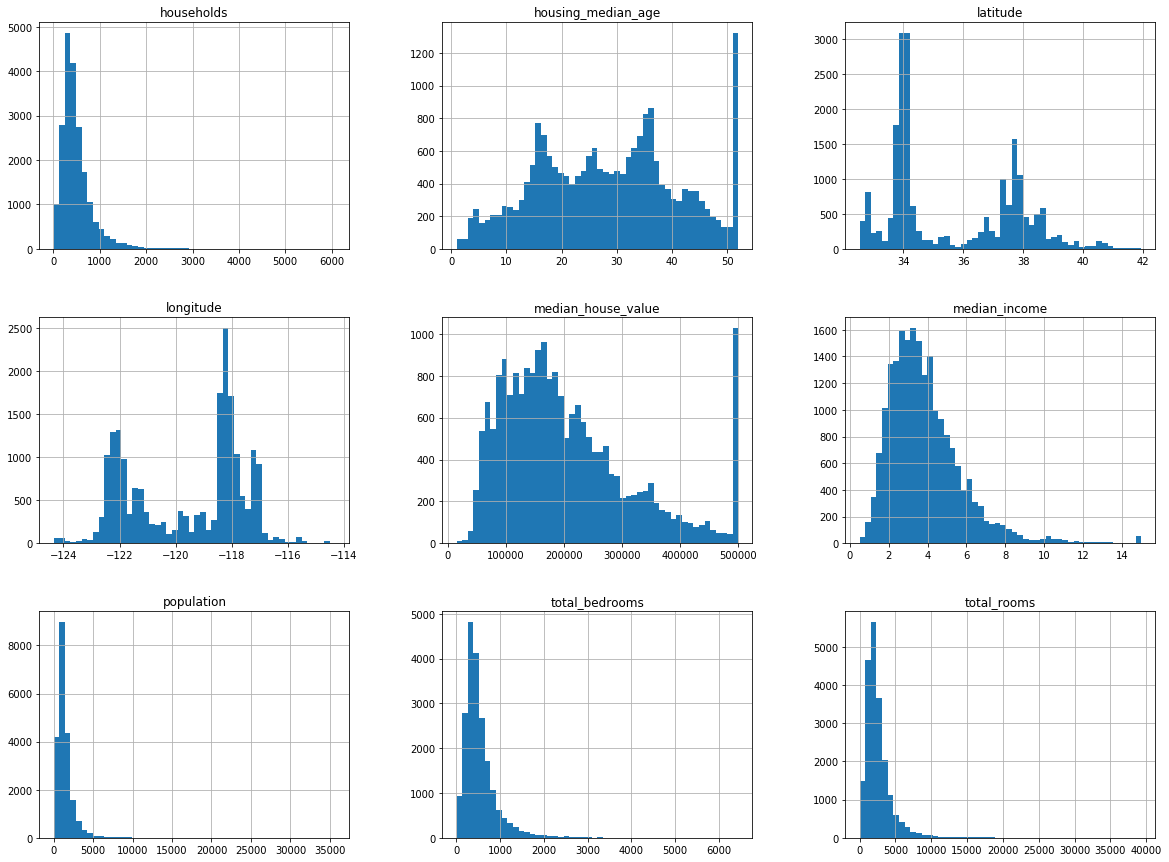

In [17]:
houses.hist(bins=50, figsize=(20,15))

Większość histogramów cechuje rozkład długoogonowy - rozciągają się znacznie bardziej po prawej stronie mediany niż po lewej.
Utrudnia to niektórym algorytmom uczenia maszynowego rozpoznawanie wzorców. Później spróbuję je przekształcić na rozkład
bardziej dzwonowy.

Utworzenie zbioru testowego

In [18]:
import numpy as np

In [19]:
# def split_train_test(data, test_ratio):
#     shuffled_indices = np.random.permutation(len(data))
#     test_set_size = int(len(data) * test_ratio)
#     test_indices = shuffled_indices[:test_set_size]
#     train_indices = shuffled_indices[test_set_size]
#     return data.iloc[train_indices], data.iloc[test_indices]

In [20]:
# train_set, test_set = split_train_test(houses,0.2)

In [21]:
# print("Uczące:",len(train_set), ", testowe:", len(test_set))

Powyższe rozwiązanie się nie sprawdzi bo po ponownym uruchomieniu zostanie wygenerowany nowy zbiór testowy.
Można zapisać zbiór testowy po jego pierwszym utworzeniu i wczytywać przy kolejnych okazjach.
Można również skorzystać z zarodka liczb pseudolosowych i uzyskiwać za każdym razem te same pseudolosowe indeksy.

Obdywa rozwiązania zawiodą po dostarczeniu nowej porcji zaktualizowanych danych!

Można temu zapobiec poprzez dobór przykładów stanowiących część zbioru testowego za pomocą ich identyfikatorów - przy założeniu,że
te identyfikatory są niepowtarzalne i niezmienne.

Obliczenia hasza identyfikatora i przechowywanie jego ostatniego bajtu - wtedy do zbioru testowego trafiłyby przykłady,
dla których końcówka hasza jest równa lub mniejsza od 51 (czyli mniej więcej 20% liczby 256)

In [22]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1]< 256 * test_ratio

In [23]:
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

Zbiór houses nie posiada kolumny z identyfikatorem. Użyje więc indeksu wiersza

In [24]:
houses_with_id = houses.reset_index() # dodanie kolumny index
train_set, test_set = split_train_test_by_id(houses_with_id, 0.2, "index")

Przy użyciu indeksu jako niepowtarzalnego identyfikatora trzeba się upwenić, że nowe informacje będą umieszczone na końcu zestawu 
danych i żaden wiersz nie zostanie nigdy usunięty. 

W przeciwnym wypadku, należy spróbwać wykorzystać najstabilniejsze cechy do stworzenia niepowtarzalnego identyfikatora

Można spróbwać go stworzyć na podstawie współrzędnych geograficznych

In [25]:
houses_with_id["id"] = houses["longitude"] * 1000 + houses["latitude"]

In [26]:
train_set,test_set  = split_train_test_by_id(houses_with_id, 0.2, "id")

Scikit-Learn zawiera kilka różnych funkcji rozdzielających zbiory danych na wiele podzbiorów. Najprostsza z nich
to train_test_split, która zawiera element random_state. Pozwala on wybrać zarodek liczb losowych. Po drugie
można przekazać wiele zbiorów danych mających taką samą liczbę wierszy - będą one rozdzielane pomiędzy te same 
indeksy (przydatne, gdy etykiety znajdą się w osobnym obiekcie DataFrame)

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
train_set, test_set = train_test_split(houses, test_size=0.2, random_state=42)

Dotychczas rozważane metody próbkowania były całkowicie losowe. To rozwiązanie spisuje się dobrze w przypadku odpowiednio dużych
zbiorów danych. W przeciwnym wypadku istnieje duże ryzyko obciążenia próbkowania. 
Dla przykładu:
    populacja USA składa się z 51,3% kobiet i  48,7% mężczyzn. Zatem prawidłowo przeprowadzona jakakolwiek ankieta powinna
    uwzględniać te proporcje tj. 513 kobiet i 487 mężczyzn. Jest to tzw. losowanie warstwowe:
    populacja zostaje rozdzielona na jednorodne podgrupy zwane wartstwami i z każdej z nich jest dobierana odpowiednia
    liczba przykładów zapewniająca prawidłowe odzwierciedlenie stanu populacji.
    Przy czysto losowym doborze przykładów istaniałoby 12-procentowe p-stwo uzyskania wypaczonego zestawu testowego
    zawierającego mniej niż 49% lub ponad 54%kobiet

Założenie:
    po rozmowie z ekspertami okazuje się, że bardzo ważny atrybut pomagający w prognozowaniu miediany cen mieszkań to mediana 
    dochodów. Można chcieć zagwarantować, żeby zbiór testowy wiernie reprezentował różne kategorie dochodów dla całego zbioru danych. 

Chcemy zagwarantować, żeby zbiór testowy wiernie reprezentował różne kategorie dochodów dla całego zbioru danych.

Mediana dochodów zgodnie z histogramem stanowi atrybut ciągłych wartości numerycznych, dlatego najpierw należy
stworzyć atrybut kategorii dochodów.

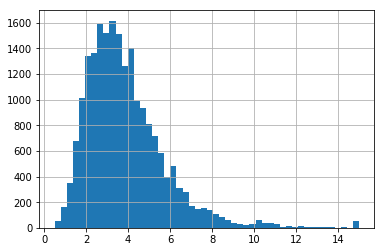

In [29]:
houses.median_income.hist(bins=50)

Mediana dodchodów nie przypomina danych podawanych w dolarach amerykańskich. Okazuje się,że zostały one 
przeskalowane i ograniczone przez zespół odpowiedzialny za zbieranie danych (do maksymalnej wartości 15 dla wyższej
mediany dochodów oraz do minimalnej wartości 0,5 dla niższej mediany dochodów).


Większość więc mieści się w przedziale 20000-50000 dolarów (między 2 a 5 na osi x), jednak niektóre przekraczają znacznie
dochód 60000 dolarów. 


Ważne, żeby każda warstwa zestawu danych zawierała wystarczającą liczbę przykładów, bo w przeciwnym razie oszacowanie znaczenia 
danej warstwy może być nieadekwatne do rzeczywistości.

Oznacza to, że nie możemy tworzyć zbyt wielu warstw i każda z nich powinna być wystarczająco duża. Poniższy kod
generuje atrybut kategorii dochodów poprzez podzielenie mediany przez 1,5 (w celu ograniczenia liczby kategorii) i
zaokrąglenie wyników za pomocą funkcji ceil (by wyodrębnić poszczególne kategorie) a następnie scalenie wszystkich
kateogrii o wartości mniejszej niż 5 w osobną kategorię.

In [30]:
houses["income_cat"] = np.ceil(houses["median_income"] / 1.5)
houses["income_cat"].where(houses["income_cat"] < 5, 5.0, inplace=True)

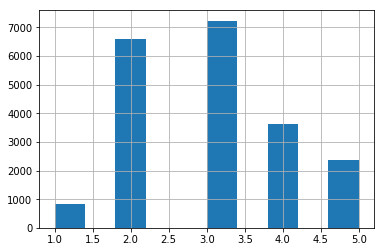

In [31]:
houses["income_cat"].hist()

Próbkowanie warstwowe na podstawie funkcji StratifiedShuffleSplit

In [32]:
from sklearn.model_selection import StratifiedShuffleSplit

In [33]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(houses, houses["income_cat"]):
    strat_train_set = houses.loc[train_index]
    strat_test_set = houses.loc[test_index]

Sprawdzenie, czy działa zgodnie z założeniami

In [34]:
houses["income_cat"].value_counts() / len(houses)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [35]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [36]:
test_set["income_cat"].value_counts() / len(test_set)

KeyError: 'income_cat'

Podsumowując zbiór testowy wygenerowany przy użyciu losowania warstwowego ma proporcje niemal identyczne,
jak uzyskane w pełnym zbiorze danych, podczas gdy wyniki uzyskane w całkowicie losowym zestawie danych wykazują
spore wypaczenie proporcji.

Teraz powinnienem usunąć atrybut income_cat, dzięki czemu dane zostaną przywrócone do pierwotnego stanu

In [37]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [38]:
# Kopia, żeby na spokojnie sobie pracować

houses = strat_train_set.copy()

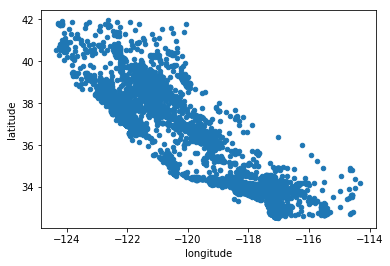

In [39]:
# Skoro dane geograficzne, warto sobie je zwizualizować
houses.plot(kind="scatter", x="longitude", y="latitude")

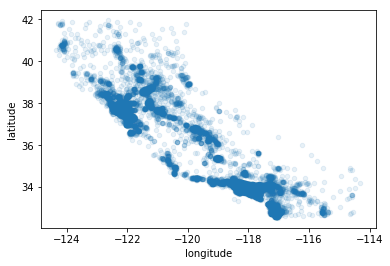

In [40]:
# Lepsza wizualizacja, ukazane obszary o dużym zagęszczeniu danych
houses.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

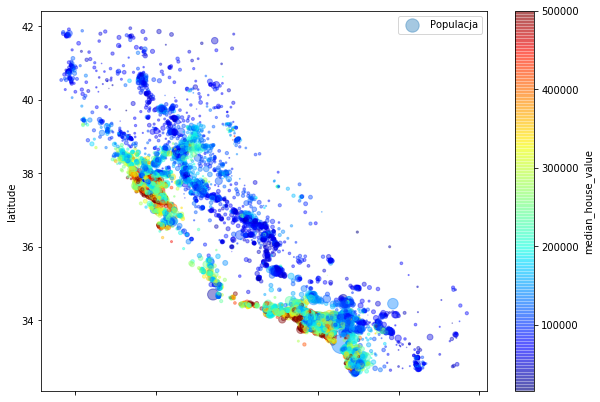

In [41]:
houses.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
           s=houses["population"]/100, label="Populacja", figsize=(10,7),
           c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

In [42]:
# Można wyczytać, że ceny mieszkań w dużej mierze są uzależnione od położenia geograficznego i zaludnienia.

Poszukiwanie korelacji

In [43]:
corr_matrix = houses.corr()

In [44]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [45]:
# Sprawdzenie każdego atrybutu z medianą cen mieszkań

In [46]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [47]:
# Analiza najbardziej obiecujących cech

In [48]:
from pandas.tools.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

C:\Users\rafal\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  if __name__ == '__main__':


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D2F780D908>,
      dtype=object)

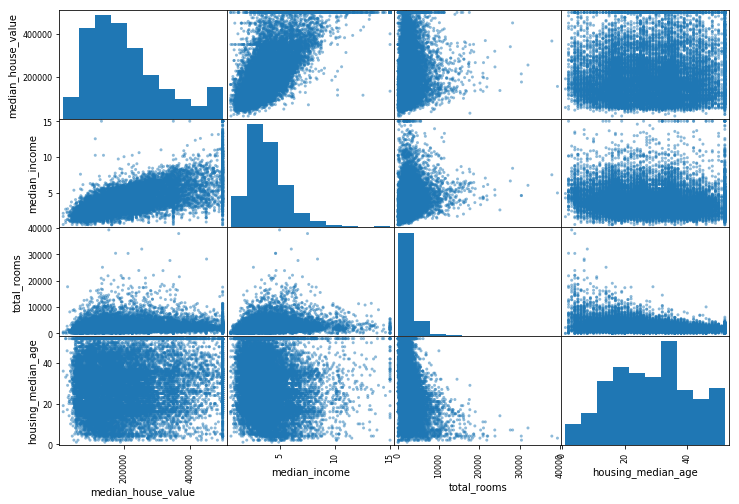

In [49]:
scatter_matrix(houses[attributes], figsize=(12,8))

In [50]:
# Najlepszy atrybut - mediana dochodów

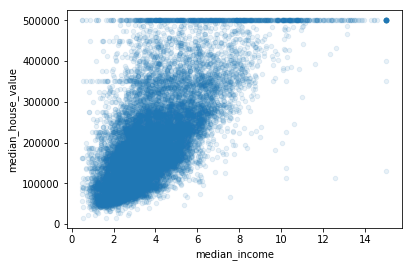

In [51]:
houses.plot(kind='scatter', x="median_income", y="median_house_value", alpha=0.1)

In [52]:
# Wypróbowwanie różnych kombinacji atrybutów
# Na przykład liczba pomieszczeń w dystrykcie nic nam nie mówi, jeśli nie wiemy, ile rodzin tam przebywa
# Szukamy liczby pokoi przypadających na rodzinę

In [53]:
houses["pokoje_na_rodzine"] = houses["total_rooms"] / houses["households"]
houses["sypialnie_na_pokoje"] = houses["total_bedrooms"] / houses["total_rooms"]
houses["populacja_na_rodzine"] = houses["population"] / houses["households"]

In [54]:
corr_matrix = houses.corr()

In [55]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.687160
pokoje_na_rodzine       0.146285
total_rooms             0.135097
housing_median_age      0.114110
households              0.064506
total_bedrooms          0.047689
populacja_na_rodzine   -0.021985
population             -0.026920
longitude              -0.047432
latitude               -0.142724
sypialnie_na_pokoje    -0.259984
Name: median_house_value, dtype: float64

In [56]:
# Sukces! nowy atrybut sypialnie_na_pokoje jest dużo lepiej skorelowany z medianą cen mieszkań niż całkowita liczba
# pomieszczeń lub sypialni

Wniosek: im więcej sypialni w stosunku do liczby pokoi tym tańsze mieszkanie 

Przygotowanie danych pod algorytm uczenia maszynowego

In [57]:
houses = strat_train_set.drop("median_house_value", axis=1)
houses_labels = strat_train_set["median_house_value"].copy()

In [58]:
# funkcja drop tworzy kopię danych i nie wpływa na zbiór strat_training_set

Większość algorytmów uczenia maszynowego nie może działać, jeśli brakuje jakiś cech, dlatego
stworzę kilka funkcji, które zajmą się tym problemem. W atr. total_bedrooms brakuje kilku wartości.
Są więc 3 możliwości
- pozbyć się dystyktów zawierających brakujące dane
- pozbyć się całego atrybutu
- uzupełnić dane o określoną wartość (zero,średnia, mediana)

In [59]:
# houses.dropna(subset=[total_bedrooms]) opcja 1
# houses.drop("total_bedrooms", axis=1) opcja 2
# median = houses["total_bedrooms"].median() # opcja 3
# houses["total_bedrooms"].fillna(median, inplace=True)

Przy obliczeniu mediany należy zapisać tą wartość. Będzie niezbędna do zastąpienia brakujących wartości w zbiorze
testowym na etapie oceny działania systemu

In [60]:
# przydatna funkcja - stworzenie klasy imputer, w której zaznaczamy że chcemy zastąpić brakujące wartości każdego
# atrybutu medianą tego atrybutu

In [61]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

In [62]:
houses

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
19480,-120.97,37.66,24.0,2930.0,588.0,1448.0,570.0,3.5395,INLAND
8879,-118.50,34.04,52.0,2233.0,317.0,769.0,277.0,8.3839,<1H OCEAN
13685,-117.24,34.15,26.0,2041.0,293.0,936.0,375.0,6.0000,INLAND
4937,-118.26,33.99,47.0,1865.0,465.0,1916.0,438.0,1.8242,<1H OCEAN
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,<1H OCEAN


In [63]:
# mediana może być wyliczana jedynie z wartości numerycznych - tworzę więc kopię zbioru niezawierającą atrybutu
# ocean_proximity

In [64]:
houses_num = houses.drop("ocean_proximity", axis=1)

In [65]:
houses_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
19480,-120.97,37.66,24.0,2930.0,588.0,1448.0,570.0,3.5395
8879,-118.50,34.04,52.0,2233.0,317.0,769.0,277.0,8.3839
13685,-117.24,34.15,26.0,2041.0,293.0,936.0,375.0,6.0000
4937,-118.26,33.99,47.0,1865.0,465.0,1916.0,438.0,1.8242
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999


In [66]:
imputer.fit(houses_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [67]:
# imputer zachowuje wyniki w zmiennej statistics_

In [68]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [69]:
houses_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [70]:
X = imputer.transform(houses_num)

In [71]:
# uzykujemy klasyczna tablice Numpy zawierajaca przeksztalcone cechy

In [72]:
houses_tr = pd.DataFrame(X, columns=houses_num.columns)

In [73]:
# Obsługa tekstu i atrybutów kategorialnych

In [74]:
# Usunąłem atrybut ocean_proximity bo ma on charakter tekstowy i nie byłem w stanie obliczyć jego mediany. 
# Większość algorytmów uczenia maszynowego woli pracować z wartościami liczbowymi dlatego przekształcam etykiety 
# tekstowe na liczby

In [75]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
houses_cat = houses["ocean_proximity"]
houses_cat_encoded = encoder.fit_transform(houses_cat)

In [76]:
houses_cat_encoded

array([0, 0, 4, ..., 1, 0, 3], dtype=int64)

In [77]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [78]:
# tekst <1H OCEAN otrzymuje wartość 0, INLAND 1 , itd